# Setting

In [1]:
# Base
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
from time import time
import itertools
import joblib
#NLP
import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import string
from textblob import TextBlob


#ML
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
# from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
#from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Gdrive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# Rimozione della punteggiatura

def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

In [4]:
# Importazione dataset e riconversione colonna in lista di stringhe, come già fatto nel preprocessing

# Gian
# df = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')
# df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
# df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [5]:
# Remo 
df = pd.read_csv('H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [6]:
# Google colab
# df = pd.read_csv('/content/gdrive/MyDrive/TextMiningProject/df_lemmatized.csv')
# df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
# df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [7]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio,WordCount,Normalized Text,Tokenized Text,Text_No_Stop_Words,Lemmatized Text
0,0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,48,i have bought several of the vitality canned d...,"['i', 'have', 'bought', 'several', 'of', 'the'...","['bought', 'several', 'vitality', 'canned', 'd...","[bought, several, vitality, canned, dog, food,..."
1,1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN,31,product arrived labelled as lumbo halted peanu...,"['product', 'arrived', 'labelled', 'as', 'lumb...","['product', 'arrived', 'labelled', 'lumbo', 'h...","[product, arrived, labelled, lumbo, halted, pe..."
2,2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,94,this is a connection that has been around a fe...,"['this', 'is', 'a', 'connection', 'that', 'has...","['connection', 'around', 'centuries', 'light',...","[connection, around, century, light, pillow, c..."
3,3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,1.0,41,if you are looking for the secret ingredient i...,"['if', 'you', 'are', 'looking', 'for', 'the', ...","['looking', 'secret', 'ingredient', 'robitussi...","[looking, secret, ingredient, robitussin, beli..."
4,4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,NaN,27,great staff at a great price there was a wide...,"['great', 'staff', 'at', 'a', 'great', 'price'...","['great', 'staff', 'great', 'price', 'wide', '...","[great, staff, great, price, wide, assortment,..."


In [8]:
df.shape

(393927, 18)

# Classificazione

In [9]:
classification_df = df[['Score', 'Lemmatized Text']]

Text(0, 0.5, 'Number of reviews')

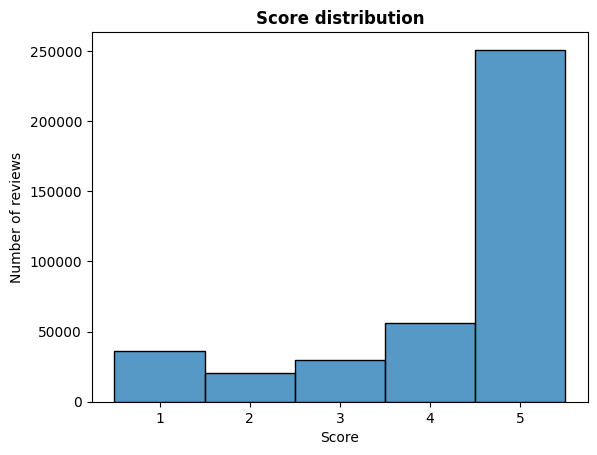

In [10]:
sns.histplot(classification_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [11]:
print(classification_df['Score'].value_counts()/len(classification_df['Score']));

5    0.637067
4    0.142392
1    0.092164
3    0.075570
2    0.052807
Name: Score, dtype: float64


Le classi sono fortemente sbilanciate, con quasi il 78% delle review appartenenti alla classe 4 e 5. E' necessaria una procedura di resampling, in modo tale che i classificatori non diano stime distorte (classificando tutte le review come appartenenti alla classe 5 si otterrebbe comunque il 63% di accuratezza).

In [12]:
# Come sample size prendo il totale delle review appartenenti alla classe meno numerosa

sample_size = classification_df.groupby('Score').count().min()[0]

In [13]:
df_downsampled = classification_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Score,Lemmatized Text
58373,1,"[total, rip, shipping, handling, total, price,..."
241438,1,"[yes, north, max, kill, bag, used, without, pr..."
34284,1,"[awful, slim, rubber, texture, disappointing, ..."
179425,1,"[dog, time, play, toy, thrown, cure, wall, cur..."
387926,1,"[tried, different, variety, natural, value, tw..."
...,...,...
241295,5,"[going, put, cereal, morning, add, protein, sh..."
14781,5,"[okis, serious, like, food, even, dont, really..."
169500,5,"[finding, branch, peanut, cluster, nightmare, ..."
272276,5,"[even, reading, review, went, ahead, made, ord..."


In [14]:
df_downsampled.shape

(104010, 2)

Text(0, 0.5, 'Number of reviews')

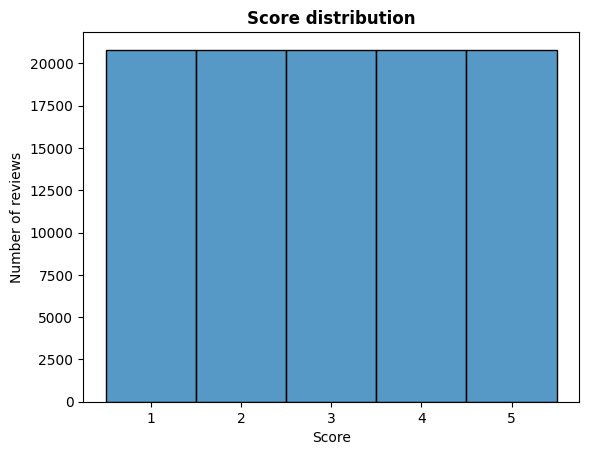

In [15]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [16]:
# Separo train e test

X_train, X_test, y_train, y_test = train_test_split(df_downsampled['Lemmatized Text'], 
                                                    df_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=df_downsampled['Score'])

# Multi-label classification

## Text representation

### Bag-of-word

In [83]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(X_train.astype(str)) 
X_train_BOW = cv_model.transform(X_train.astype(str))

In [84]:
X_train_BOW.shape

(72807, 80667)

Devo necessariamente ridurre la dimensionalità della matrice. Applico una SVD senza assegnare il numero di componenti da considerare e poi usiamo la funzione cusum() per ottenere la varianza cumulata, quindi teniamo un numero di componenti necessarie per raggiungere una certa soglia di varianza cumulata (fissata a priori).

Considerando l'elevata dimensionalità del dataset, non è possibile stimare l'intera SVD. Viene quindi considerato un numero comunque elevato di componenti, e.g. 1000, per poi andare a valutare la varianza cumulata. 

In [19]:
# Già eseguita e salvata, non runnare

# Eseguo la SVD
# n_components = 3000
# tSVD_BOW = TruncatedSVD(n_components = n_components)
# SVD_BOW = tSVD_BOW.fit(X_train_BOW)

# Calcolo varianza cumulata delle componenti
# cum_var = np.cumsum(SVD_BOW.explained_variance_ratio_)

# Salvo SVD su disco
# joblib.dump(SVD_BOW, "SVD_BOW_3000.joblib")

In [85]:
# carico SVD
SVD_BOW_3000 = joblib.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_3000.joblib")
cum_var = np.cumsum(SVD_BOW_3000.explained_variance_ratio_)

In [21]:
# Carico SVD - Google colab
# SVD_path = '/content/gdrive/MyDrive/TextMiningProject/SVD_BOW_3000.joblib'
# SVD_BOW_3000 = joblib.load(SVD_path)
# cum_var = np.cumsum(SVD_BOW_3000.explained_variance_ratio_)

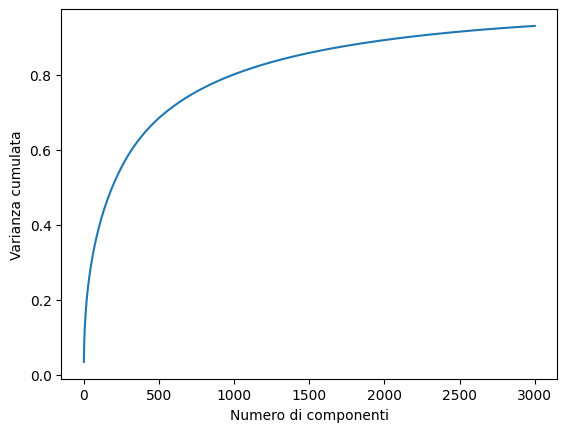

In [22]:
# Grafico varianza cumulata
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Numero di componenti")
plt.ylabel("Varianza cumulata")
plt.show()

Fissiamo una threshold pari all'85%. Ciò vuol dire che andremo a considerare un numero di componenti necessarie per arrivare ad una varianza spiegata pari all'85%

In [23]:
threshold = 0.85
n_components = np.argmax(cum_var >= threshold) + 1
print("Numero di componenti necessariea spiegare una varianza pari all'85% sono : ", n_components)

Numero di componenti necessariea spiegare una varianza pari all'85% sono :  1413


In [86]:
# Stimo SVD ottimale, già runnato 
tSVD_BOW = TruncatedSVD(n_components = 1413)
SVD_BOW = tSVD_BOW.fit(X_train_BOW)

# Salvo SVD ottimizzata
joblib.dump(SVD_BOW, "H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_optim.joblib")

['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_optim.joblib']

In [89]:
# Inizializzo SVD con componenti ottimali
tSVD_BOW = TruncatedSVD(n_components = 1413)

# Carico SVD ottimizzata 
loaded_svd = joblib.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_BOW_optim.joblib")
loaded_svd.fit(X_train_BOW)

TruncatedSVD(n_components=1413)

In [88]:
# Applico la trasformazione al training e test set 
X_train_BOW = tSVD_BOW.transform(X_train_BOW)

X_test_BOW = cv_model.transform(X_test.astype(str))
X_test_BOW = loaded_svd.transform(X_test_BOW)

NotFittedError: This TruncatedSVD instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### Implementazione algoritmi

- Regressione Logistica
- Random Forest
- KNN
- XGboost

##### Regressione logistica

In [26]:
# Già eseguito, non runnare
# Regressione logistica con ottimizzazione degli iperparametri
# model = LogisticRegression(random_state=1)

#Iperparametri "critici" da ottimizzare 
# solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# penalty = ['None', 'l2']
# c_values = [500, 200, 100, 50, 10, 1.0, 0.1, 0.01, 0.001]

# Definisco la griglia di ricerca
# grid = dict(solver=solvers,penalty=penalty,C=c_values)

# Start the clock, train the classifier, then stop the clock
# start = time()

# CV and Tuning
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/logreg_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [27]:
# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/logreg_gridsearch_BOW.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

#Salvo il modello con le migliori performance
model_lr_BOW = loaded_grid_search.best_estimator_

Best result: 0.485791 using {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}


##### Random Forest

In [28]:
# Random Forest, già runnato !!
# model = RandomForestClassifier()

# Parametri 'critici' da ottimizzare
# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']
# Definisco la griglia di ricerca 
# grid = dict(n_estimators=n_estimators,max_features=max_features)

# Start the clock, train the classifier, then stop the clock
# start = time()

# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy', error_score=0)
# grid_result = grid_search.fit(X_train_BOW, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/rf_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [29]:

# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/rf_gridsearch_BOW.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_rf_BOW = loaded_grid_search.best_estimator_

Best result: 0.375527 using {'max_features': 'sqrt', 'n_estimators': 1000}


##### KNN

In [30]:
# model = KNeighborsClassifier(weights='distance')
# # Parametri critici da
# n_neighbors = range(1, 21, 4)

# # Definisco la griglia di ricerca
# grid = dict(n_neighbors=n_neighbors)

# # Start the clock, train the classifier, then stop the clock
# start = time()
# random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
# grid_result = random_search.fit(X_train_BOW, y_train)
# end = time()
# print ("Train and tuning model in {:.4f} seconds".format(end - start))
# # Summary dei risultati
# print("Best result: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_BOW.joblib'
# joblib.dump(grid_result, path)

In [31]:
# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_BOW.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_BOW = loaded_grid_search.best_estimator_

Best result: 0.319585 using {'n_neighbors': 17}


##### XG-Boost

**Holdout**

**Ottimizzazione degli iper-parametri**

Viene effettuata una ottimizzazione degli iper-parametri con metodo RandomSearch. 

Parametri ottimizzati

- max_depth = profondità massima dell'albero di decisione utilizzato in una singola iterazione. 
- eta (a.k.a learning rate) = un valore compreso tra 0 e 1 che controlla la velocità di apprendimento dell'algoritmo.  
- colsample_bytree = un valore compreso tra 0 e 1 che rappresenta la frazione di colonne utilizzate in ciascuna iterazione.
- sampling_method = specifica il metodo di campionamento utilizzato per selezionare le osservazioni da utilizzare in ciascuna iterazione.

In [34]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

le = LabelEncoder()
y_train_xg = le.fit_transform(y_train)

# XG-Boost con ottimizzazione degli iperparametri
model = XGBClassifier( tree_method = 'gpu_hist', predictor = 'gpu_predictor')

# Parametri critici da ottimizzare
max_depth = [1,2,3, 4, 5, 6, 7, 8, 9]
eta  = [0.001, 0.01, 0.01, 0.2, 0.4, 0.6, 0.8]
colsample_bytree = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
sampling_method = ['uniform', 'gradient_based']

#Definisco la griglia di ricerca
grid = dict(max_depth=max_depth, eta =eta, colsample_bytree = colsample_bytree, sampling_method = sampling_method)

# Start the clock, train the classifier, then stop the clock
start = time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter= 6, cv=2, scoring='accuracy', error_score=0, n_jobs=-1, random_state=0, verbose=4)
grid_result = random_search.fit(X_train_BOW, y_train_xg)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_gridsearch_BOW.joblib'
joblib.dump(grid_result, path)

# Salvataggio dei risultati del tuning Google-Colab
# model_path = '/content/gdrive/MyDrive/TextMiningProject/xgboost_gridsearch_BOW.joblib'
# joblib.dump(grid_result, model_path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Train and tuning model in 652.3020 seconds


['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_gridsearch_BOW.joblib']

In [35]:
# Caricamento del risultato del tuning
path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_gridsearch_BOW.joblib'
loaded_grid_search = joblib.load(path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_xgboost_BOW = loaded_grid_search.best_estimator_

Best result: 0.413065 using {'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.5}


In [ ]:
# y_test = le.fit_transform(y_test)
# y_pred = model_xgboost_BOW.predict(X_test_BOW)
# print(accuracy_score(y_test, y_pred))

#### Analizzo i risultati:

In [41]:
models = [model_lr_BOW, model_rf_BOW, model_knn_BOW, model_xgboost_BOW]

# Previsioni sul test set
results = []
for model in models:
    if model == models[3]:
        y_test_xg = le.fit_transform(y_test)
        print(y_test_xg)
        y_pred = model.predict(X_test_BOW)
        acc = accuracy_score(y_test_xg, y_pred)
        prec = precision_score(y_test_xg, y_pred, average='macro')
        recall = recall_score(y_test_xg, y_pred, average='macro')
        f1 = f1_score(y_test_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_BOW)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Creo la tabella e visualizzo i risultati
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'RF model', 'KNN model', 'XGBOOST model']
print(df_results)

[3 2 1 ... 4 3 2]
               Accuracy  Precision    Recall  F1 Score
LR model       0.220492   0.218392  0.220489  0.217826
RF model       0.297535   0.293372  0.297532  0.291559
KNN model      0.226613   0.228918  0.226612  0.221385
XGBOOST model  0.430119   0.422836  0.430112  0.425273


In [47]:
models[1]

RandomForestClassifier(n_estimators=1000)

In [ ]:
# Crea i grafici ROC per ogni modello
# for model in models:
#     y_pred_proba = model.predict_proba(X_test_BOW)[::,1]
#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#     auc = roc_auc_score(y_test, y_pred_proba)
#     plt.plot(fpr,tpr,label="AUC="+str(auc))
#     plt.legend(loc = 'lower right')

In [ ]:
# # Creo le matrici di confusione per ogni modello
# for model in models:
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure()
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title("Confusion Matrix - " + str(model))
#     plt.colorbar()
#     tick_marks = np.arange(3)
#     plt.xticks(tick_marks, ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
#     plt.yticks(tick_marks, ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j]),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

### **TF-IDF**

In [58]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True) 
tv_model = tv.fit(X_train.astype(str)) 
X_train_TFIDF = tv.transform(X_train.astype(str)) # Vettorizzo

In [59]:
X_train_TFIDF.shape

(72807, 80667)

In [ ]:
# Già eseguita e salvata, non runnare

# Eseguo SVD
# n_components = 5000
# tSVD_TFIDF = TruncatedSVD(n_components = n_components)
# SVD_TFIDF_5000 = tSVD_TFIDF.fit(X_train_TFIDF)

# Calcolo varianza cumulata delle componenti
# cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

# Salvo SVD su disco
# joblib.dump(SVD_TFIDF_5000, "SVD_TFIDF_5000.joblib")


In [50]:
# Carico SVD
SVD_TFIDF_5000 = joblib.load("H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/SVD_TFIDF_5000.joblib")
cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

In [ ]:
# Carico SVD - Google Colab
# SVD_TFIDF_5000 = joblib.load("/content/gdrive/MyDrive/TextMiningProject/SVD_TFIDF_5000.joblib")
# cum_var = np.cumsum(SVD_TFIDF_5000.explained_variance_ratio_)

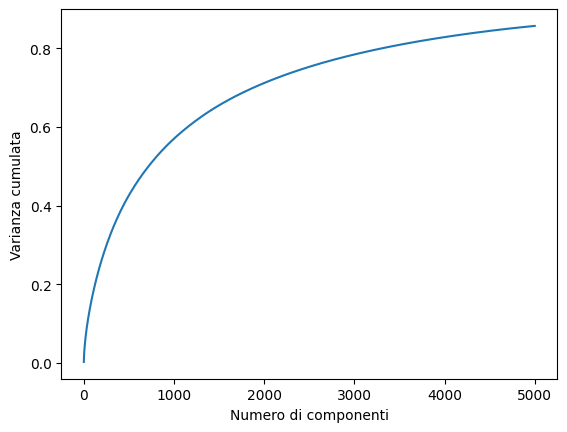

In [60]:
# Grafico varianza cumulata
plt.plot(range(1, len(cum_var) + 1), cum_var)
plt.xlabel("Numero di componenti")
plt.ylabel("Varianza cumulata")
plt.show()

In [61]:
threshold = 0.85
n_components = np.argmax(cum_var >= threshold) + 1
print("Numero di componenti necessariea spiegare una varianza pari all'85% sono : ", n_components)

Numero di componenti necessariea spiegare una varianza pari all'85% sono :  4719


In [ ]:
# Stimo SVD ottimale
tSVD_TFIDF = TruncatedSVD(n_components = 4719)
SVD_TFIDF = tSVD_TFIDF.fit(X_train_TFIDF)

In [ ]:
# Applico la trasformazione al training e test set 
X_train_TFIDF = tSVD_TFIDF.transform(X_train_TFIDF)

X_test_TFIDF = tv_model.transform(X_test.astype(str))
X_test_TFIDF = SVD_TFIDF.transform(X_test_TFIDF)

#### Implementazione algoritmi

- Regressione Logistica
- KNN
- XGBoost

##### Regressione Logistica

In [ ]:

# Regressione logistica con ottimizzazione degli iperparametri
model = LogisticRegression(random_state=1)

# Iperparametri "critici" da ottimizzare 
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['None', 'l2']
c_values = [500, 200, 100, 50, 10, 1.0, 0.1, 0.01, 0.001]

# Definisco la griglia di ricerca
grid = dict(penalty=penalty,C=c_values)

# Start the clock, train the classifier, then stop the clock
start = time()

# CV and Tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
grid_result = random_search.fit(X_train_TFIDF, y_train)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/lrr_gridsearch_TFIDF.joblib'
# joblib.dump(grid_result, path)

model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_TFIDF.joblib'
joblib.dump(grid_result, model_path)

In [ ]:
# Caricamento del risultato del tuning

# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/lrr_gridsearch_TFIDF.joblib'
# loaded_grid_search = joblib.load(path)
model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_TFIDF.joblib'
loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

#Salvo il modello con le migliori performance
model_lr_TFIDF = loaded_grid_search.best_estimator_

##### KNN

In [ ]:
model = KNeighborsClassifier(weights='distance')
# Parametri critici da
n_neighbors = range(1, 21, 1)

# Definisco la griglia di ricerca
grid = dict(n_neighbors=n_neighbors)

# Start the clock, train the classifier, then stop the clock
start = time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter=6 ,cv=2, scoring="accuracy", error_score=0, verbose=3)
#grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy',error_score=0)
grid_result = random_search.fit(X_train_TFIDF, y_train)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning

# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_TFIDF.joblib'
# loaded_grid_search = joblib.load(path)
model_path = '/content/gdrive/MyDrive/TextMiningProject/knn_gridsearch_TFIDF.joblib'
joblib.dump(grid_result, model_path)

In [ ]:
# Caricamento del risultato del tuning

# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/knn_gridsearch_TFIDF.joblib'
# loaded_grid_search = joblib.load(path)
model_path = '/content/gdrive/MyDrive/TextMiningProject/knn_gridsearch_TFIDF.joblib'
loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_knn_TFIDF = loaded_grid_search.best_estimator_

##### XGBoost

Viene effettuata una ottimizzazione degli iper-parametri con metodo RandomSearch. 

Parametri ottimizzati

- max_depth = profondità massima dell'albero di decisione utilizzato in una singola iterazione. 
- eta (a.k.a learning rate) = un valore compreso tra 0 e 1 che controlla la velocità di apprendimento dell'algoritmo.  
- colsample_bytree = un valore compreso tra 0 e 1 che rappresenta la frazione di colonne utilizzate in ciascuna iterazione.
- sampling_method = specifica il metodo di campionamento utilizzato per selezionare le osservazioni da utilizzare in ciascuna iterazione.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

le = LabelEncoder()
y_train_xg = le.fit_transform(y_train)

# XG-Boost con ottimizzazione degli iperparametri
model = XGBClassifier( tree_method = 'gpu_hist', predictor = 'gpu_predictor')

# Parametri critici da ottimizzare
max_depth = [1,2,3, 4, 5, 6, 7, 8, 9]
eta  = [0.001, 0.01, 0.01, 0.2, 0.4, 0.6, 0.8]
colsample_bytree = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
sampling_method = ['uniform', 'gradient_based']

#Definisco la griglia di ricerca
grid = dict(max_depth=max_depth, eta =eta, colsample_bytree = colsample_bytree, sampling_method = sampling_method)

# Start the clock, train the classifier, then stop the clock
start = time()
random_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_iter= 6, cv=2, scoring='accuracy', error_score=0, n_jobs=-1, random_state=0, verbose=3)
grid_result = random_search.fit(X_train_TFIDF, y_train_xg)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_gridsearch_TFIDF.joblib'
# joblib.dump(grid_result, path)

# Salvataggio dei risultati del tuning Google-Colab
model_path = '/content/gdrive/MyDrive/TextMiningProject/xgboost_gridsearch_TFIDF.joblib'
joblib.dump(grid_result, model_path)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Train and tuning model in 652.3020 seconds


['H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_gridsearch_BOW.joblib']

In [ ]:
# Caricamento del risultato del tuning
# path = 'H:/.shortcut-targets-by-id/1veNClNl7CxCTFHVNY2Fp29hcMoEj-the/TextMiningProject/Model_estimated/xgboost_gridsearch_TFIDF.joblib'
# loaded_grid_search = joblib.load(path)

model_path = '/content/gdrive/MyDrive/TextMiningProject/xgboost_gridsearch_TFIDF.joblib'
loaded_grid_search = joblib.load(model_path)

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_xgboost_TFIDF = loaded_grid_search.best_estimator_

Best result: 0.413065 using {'max_depth': 6, 'eta': 0.2, 'colsample_bytree': 0.5}


### Analisi dei risultati

In [ ]:
models = [model_lr_TFIDF, model_knn_TFIDF, model_xgboost_TFIDF]

# Previsioni sul test set
results = []
for model in models:
    if model == models[2]:
        y_test_xg = le.fit_transform(y_test)
        print(y_test_xg)
        y_pred = model.predict(X_test_TFIDF)
        acc = accuracy_score(y_test_xg, y_pred)
        prec = precision_score(y_test_xg, y_pred, average='macro')
        recall = recall_score(y_test_xg, y_pred, average='macro')
        f1 = f1_score(y_test_xg, y_pred, average='macro')
        results.append([acc, prec, recall, f1])
    else:
        y_pred = model.predict(X_test_TFIDF)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([acc, prec, recall, f1])

# Creo la tabella e visualizzo i risultati
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'KNN model', 'XGBOOST model']
print(df_results)

In [ ]:
# # Crea i grafici ROC per ogni modello
# for model in models:
#     y_pred_proba = model.predict_proba(X_test_BOW)[::,1]
#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#     auc = roc_auc_score(y_test, y_pred_proba)
#     plt.plot(fpr,tpr,label="AUC="+str(auc))
#     plt.legend(loc = 'lower right')

In [ ]:
# # Creo le matrici di confusione per ogni modello
# for model in models:
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure()
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title("Confusion Matrix - " + str(model))
#     plt.colorbar()
#     tick_marks = np.arange(3)
#     plt.xticks(tick_marks, ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
#     plt.yticks(tick_marks, ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j]),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()

### W2V Representation

In [ ]:
# Creo il modello W2V sul training
w2v_model = gensim.models.Word2Vec(X_train, vector_size=300, window=8, min_count=2)

Ho a disposizione il modello W2V, che ha convertito ogni parola presente nel training (nello specifico, deve essere presente almeno
due volte --> min_count=2) in un vettore a 100 componenti. Per generare un vettore rappresentativo di ciascuna review andrò a creare un
vettore costituito dalla media (componente per componente) dei vettori delle parole appartenenti alla review. (https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381)

In [ ]:
words = set(w2v_model.wv.index_to_key) # Lista di parole presenti nel modello W2V

# Creo due liste, una per il training e una per il test. Ciascuna lista contiene come elementi delle altre liste. 
# Ciascun elemento (ciascuna lista) contiene i vettori relativi alle parole di una specifica review (una lista per review contenente i vettori delle singole parole)

X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

Per spiegare meglio quanto fatto sopra uso questo esempio:

In [ ]:
# La prima review del training è la seguente
X_train.head(1)

In [ ]:
# Le prime due parole sono 'love' e 'walker'. Stampo i vettori di queste due parole
w2v_model.wv.get_vector('love')

In [ ]:
w2v_model.wv.get_vector('walker')

Per vedere che sono identici, stampo i primi due elementi della prima lista in X_train_vec. Questi due elementi corrispondono ai vettori delle prime due parole della review selezionata, ossia 'love' e 'walker'

In [ ]:
X_train_vect[0][0]

In [ ]:
X_train_vect[0][1]

Andremo a fare un loop su queste liste. Ogni frase avrà un diverso numero di parole e di conseguenza un numero differente di array da mediare

In [ ]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(300, dtype=float))

In [ ]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

Come si vede dal for eseguito qui sopra, ogni frase, indipendentemente dal numero di parole che la compongono, corrisponde a un vettore con 300 componenti, creato nello specifico mediando i vettori delle singole parole componente per componente.

In [ ]:
# Salvo gli embedding


In [ ]:
# Carico gli embedding

#### Implementazione algoritmi

**X_train_vect_avg e X_test_vect_avg sono i vettori di feature da utilizzare, rispettivamente, per il training del modello e per le previsioni sul test set**

#### Implementazione algoritmi

- Regressione Logistica
- Random Forest
- SVM
- XGBoost

##### Regressione Logistica

In [ ]:

# Regressione logistica con ottimizzazione degli iperparametri
model = LogisticRegression(random_state=1)

# Iperparametri "critici" da ottimizzare 
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['None', 'l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Definisco la griglia di ricerca
grid = dict(solver=solvers,penalty=penalty,C=c_values)

# Start the clock, train the classifier, then stop the clock
start = time()

# CV and Tuning
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_vect_avg, y_train)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# joblib.dump(grid_result, 'logreg_gridsearch_TFIDF.joblib')

model_path = '/content/gdrive/MyDrive/TextMiningProject/logreg_gridsearch_w2v.joblib'
joblib.dump(grid_result, model_path)

In [ ]:
# Caricamento del risultato del tuning
loaded_grid_search = joblib.load('./Model_estimated/logreg_gridsearch_w2v.joblib')

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

#Salvo il modello con le migliori performance
model_lr_w2v = loaded_grid_search.best_estimator_

##### Random Forest

In [ ]:
# Random Forest
model = RandomForestClassifier()

# Parametri 'critici' da ottimizzare
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
#Definisco la griglia di ricerca 
grid = dict(n_estimators=n_estimators,max_features=max_features)

# Start the clock, train the classifier, then stop the clock
start = time()

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=2, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_vect_avg, y_train)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
joblib.dump(grid_result, 'rf_gridsearch_TFIDF.joblib')

model_path = '/content/gdrive/MyDrive/TextMiningProject/rf_gridsearch_w2v.joblib'
joblib.dump(grid_result, model_path)

In [ ]:

# Caricamento del risultato del tuning
loaded_grid_search = joblib.load('rf_gridsearch_w2vjoblib')

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_rf_w2v = loaded_grid_search.best_estimator_

##### KNN

##### XGBoost

Parametri fissati: 
- subsample = 0.5 (valore basso per contenere overfitting)
- max_depth = 5 (valore intermedio, non troppo basso per permettere al modello di comprendere pattern complessi, non troppo alto per evitare overfitting)

Parametri da ottimizzare: 
- n_estimators [10, 100, 1000]
- learning_rate in [0.01, 0.1, 0.5]

L'ottimo sarebbe ottimizzare tutti e quattro questi parametri, ma la potenza computazionale disponibile non è sufficiente 

In [ ]:
# XG-Boost con ottimizzazione degli iperparametri
model = GradientBoostingClassifier(subsample=0.5, max_depth=5)

# Parametri critici da
n_estimators = [10, 100, 1000]
learning_rate = [0.01, 0.1, 0.5]

#Definisco la griglia di ricerca
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

# Start the clock, train the classifier, then stop the clock
start = time()

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv =2, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train_vect_avg, y_train)
end = time()
print ("Train and tuning model in {:.4f} seconds".format(end - start))

# Salvataggio dei risultati del tuning
# joblib.dump(grid_result, 'xgboost_gridsearch_TFIDF.joblib')

# Salvataggio dei risultati del tuning Google-Colab
model_path = '/content/gdrive/MyDrive/TextMiningProject/xgboost_gridsearch_w2v.joblib'
joblib.dump(grid_result, model_path)

In [ ]:
# Caricamento del risultato del tuning
loaded_grid_search = joblib.load('xgboost_gridsearch_w2v.joblib')

# Summary dei risultati
print("Best result: %f using %s" % (loaded_grid_search.best_score_, loaded_grid_search.best_params_))

# Salvo il modello con le migliori perfomance
model_xgboost_w2v = loaded_grid_search.best_estimator_


### Analisi dei risultati

In [ ]:
models = [model_lr_w2v, model_rf_w2v, model_svm_w2v, model_xgboost_w2v]

# Previsioni sul test set
results = []
for model in models:
    y_pred = model.predict(X_test_vect_avg)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([acc, prec, recall, f1])

# Creo la tabella e visualizzo i risultati
df_results = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_results.index = ['LR model', 'RF model', 'SVM model', 'XGBOOST model']
print(df_results)

In [ ]:
# Crea i grafici ROC per ogni modello
for model in models:
    y_pred_proba = model.predict_proba(X_test_BOW)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.legend(loc = 'lower right')

In [ ]:
# Creo le matrici di confusione per ogni modello
for model in models:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - " + str(model))
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
    plt.yticks(tick_marks, ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#### Analizzo i risultati:

##### Regressione logistica

##### Random Forest

# Binary Classification 

In [ ]:
# Tengo solo gli score diversi da 3
df_binary = classification_df[classification_df['Score']!=3]

In [ ]:
# Creo variabile binaria
df_binary.loc[df_binary.Score < 3, "Score"] = 0
df_binary.loc[df_binary.Score > 3, "Score"] = 1
df_binary.head()

In [ ]:
sns.histplot(df_binary['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [ ]:
sample_size_binary = df_binary.groupby('Score').count().min()[0]
sample_size_binary

In [ ]:
binary_downsampled = df_binary.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size_binary))
binary_downsampled

In [ ]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(binary_downsampled["Lemmatized Text"], 
                                                    binary_downsampled["Score"], 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=binary_downsampled['Score'])

### BOW

In [ ]:
cv_bin = CountVectorizer(min_df=0., max_df=1.0)
cv_model_bin = cv_bin.fit(X_train_bin.astype(str)) 
X_train_BOW_bin = cv_model_bin.transform(X_train_bin.astype(str))

In [ ]:
tSVD_BOW_bin = TruncatedSVD(n_components = 1000)
SVD_BOW_bin = tSVD_BOW_bin.fit(X_train_BOW_bin)
X_train_BOW_bin = tSVD_BOW_bin.transform(X_train_BOW_bin)
print(SVD_BOW_bin.explained_variance_ratio_.sum())

In [ ]:
X_test_BOW_bin = cv_model_bin.transform(X_test_bin.astype(str))
X_test_BOW_bin = SVD_BOW_bin.transform(X_test_BOW_bin)

In [ ]:
# Regressione

lr_BOW_bin = LogisticRegression(random_state=1)
model_lr_BOW_bin = lr_BOW_bin.fit(X_train_BOW_bin, y_train_bin)
predictions_lr_BOW_bin = model_lr_BOW_bin.predict(X_test_BOW_bin)

In [ ]:
# Random Forest

rf_BOW_bin = RandomForestClassifier(n_jobs = -1)
model_rf_BOW_bin = rf_BOW_bin.fit(X_train_BOW_bin, y_train_bin)
predictions_rf_BOW_bin = model_rf_BOW_bin.predict(X_test_BOW_bin)

Performance:

In [ ]:
evaluation(predictions_lr_BOW_bin, y_test_bin)

In [ ]:
evaluation(predictions_rf_BOW_bin, y_test_bin)

### TF-IDF

In [ ]:
tv_bin = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model_bin = tv_bin.fit(X_train_bin.astype(str))
X_train_TFIDF_bin = tv_bin.transform(X_train_bin.astype(str))

In [ ]:
tSVD_TFIDF_bin = TruncatedSVD(n_components = 1000)
SVD_TFIDF_bin = tSVD_TFIDF_bin.fit(X_train_TFIDF_bin)
X_train_TFIDF_bin = tSVD_TFIDF_bin.transform(X_train_TFIDF_bin)
print(SVD_TFIDF_bin.explained_variance_ratio_.sum())

In [ ]:
X_test_TFIDF_bin = tv_model_bin.transform(X_test_bin.astype(str))
X_test_TFIDF_bin = SVD_TFIDF_bin.transform(X_test_TFIDF_bin)

In [ ]:
# Regressione

lr_TFIDF_bin = LogisticRegression(random_state=1)
model_lr_TFIDF_bin = lr_TFIDF_bin.fit(X_train_TFIDF_bin, y_train_bin)
predictions_lr_TFIDF_bin = model_lr_TFIDF_bin.predict(X_test_TFIDF_bin)

In [ ]:
# Random Forest

rf_TFIDF_bin = RandomForestClassifier(n_jobs = -1)
model_rf_TFIDF_bin = rf_TFIDF_bin.fit(X_train_TFIDF_bin, y_train_bin)
predictions_rf_TFIDF_bin = model_rf_TFIDF_bin.predict(X_test_TFIDF_bin)

Performance:

In [ ]:
evaluation(predictions_lr_TFIDF_bin, y_test_bin)

In [ ]:
evaluation(predictions_rf_TFIDF_bin, y_test_bin)

### W2V

In [ ]:
w2v_model_bin = gensim.models.Word2Vec(X_train_bin, vector_size=300, window=8, min_count=2)

In [ ]:
words_bin = set(w2v_model_bin.wv.index_to_key) 

X_train_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
                         for ls in X_train_bin])
X_test_bin_vect = np.array([np.array([w2v_model_bin.wv[i] for i in ls if i in words_bin])
                         for ls in X_test_bin])

In [ ]:
X_train_bin_vect_avg = []
for v in X_train_bin_vect:
    if v.size:
        X_train_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_train_bin_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_bin_vect_avg = []
for v in X_test_bin_vect:
    if v.size:
        X_test_bin_vect_avg.append(v.mean(axis=0))
    else:
        X_test_bin_vect_avg.append(np.zeros(300, dtype=float))

In [ ]:
# Regressione logistica

lr_bin_W2V = LogisticRegression(random_state=1)
model_lr_bin_W2V = lr_bin_W2V.fit(X_train_bin_vect_avg, y_train_bin)
predictions_lr_bin_W2V = model_lr_bin_W2V.predict(X_test_bin_vect_avg)

In [ ]:
# Random Forest

rf_bin_W2V = RandomForestClassifier(n_jobs = -1)
model_rf_bin_W2V = rf_bin_W2V.fit(X_train_bin_vect_avg, y_train_bin)
predictions_rf_bin_W2V = model_rf_bin_W2V.predict(X_test_bin_vect_avg)

Performance:

In [ ]:
evaluation(predictions_lr_bin_W2V, y_test_bin)

In [ ]:
evaluation(predictions_rf_bin_W2V, y_test_bin)

# Idee successive

- Usare altri altri modelli (SVM, KNN, ...)
- Valutare considerazioni su downsampling
- Iperparametri della SVD per la riduzione della dimensionalità (?)
- Ottimizzazione iperparametri (specialmente su W2V, usare skipgram/cbow, e ottimizzare finestra, ecc...)
- BERT (?)